In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


In [2]:
# 2. Keras-Tuner 라이브러리 설치 (Colab에 기본 설치되어 있지 않음)
!pip install keras-tuner -q

#@title 2. 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# ML / DL 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Keras Tuner
import keras_tuner as kt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# 경고 메시지 무시
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras-Tuner Version: {kt.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00
TensorFlow Version: 2.19.0
Keras-Tuner Version: 1.4.7


In [3]:
#@title 3. 데이터 로드 및 기본 정보 확인

# ----------------------------------------------------------------------
# [중요!] 사용자의 Google Drive에 업로드된 train.csv 파일의 *전체 경로*를 입력하세요.
# (이 노트북은 train.csv 파일만 사용하여 학습 및 검증을 수행합니다.)
# ----------------------------------------------------------------------
BASE_PATH = "/content/data" # <-- 기본 폴더 경로 (수정)
TRAIN_DATA_PATH = os.path.join(BASE_PATH, "train.csv") # <-- 훈련 파일 경로 (수정)

try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    print(f"Training data loaded successfully from: {TRAIN_DATA_PATH}")
    print(f"Data shape: {df_train.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {TRAIN_DATA_PATH}")
    print("Please upload 'train.csv' to your Google Drive and update the TRAIN_DATA_PATH variable.")
except Exception as e:
    print(f"An error occurred: {e}")

Training data loaded successfully from: /content/data/train.csv
Data shape: (100000, 28)


In [4]:
# 데이터 샘플 확인
print("\n--- Data Head ---")
print(df_train.head())


--- Data Head ---
       ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   Outstanding_Debt Credit_Util

In [5]:
# 데이터 정보 확인 (Null 값 및 Dtype)
print("\n--- Data Info (Checking Dtypes and Nulls) ---")
df_train.info()


--- Data Info (Checking Dtypes and Nulls) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13

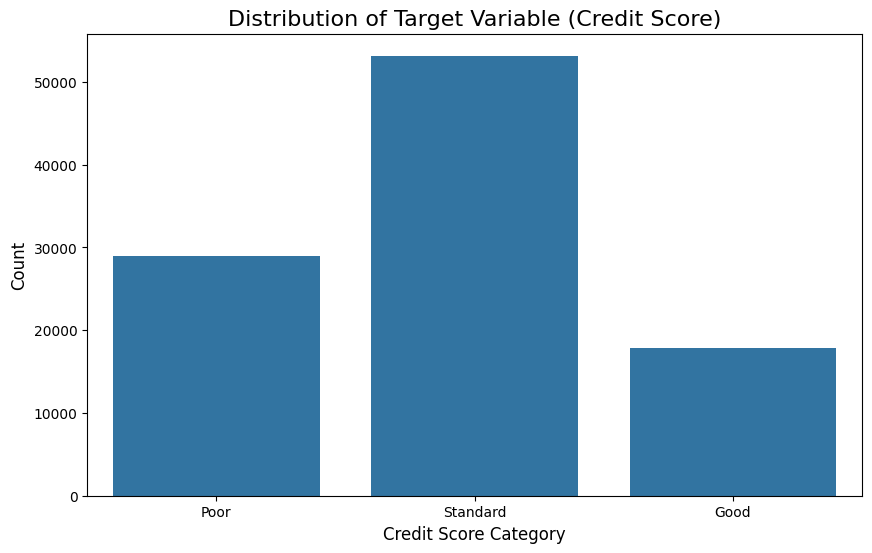

Analysis: The dataset is significantly imbalanced.
'Standard' score has the most samples, while 'Poor' has the fewest.


In [6]:
#@title 4. [EDA] Target 변수 분포 확인 (영문 Plot)
# (이 데이터셋은 'Credit_Score'가 타겟 변수입니다)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Credit_Score', order=['Poor', 'Standard', 'Good'])
plt.title('Distribution of Target Variable (Credit Score)', fontsize=16)
plt.xlabel('Credit Score Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

print("Analysis: The dataset is significantly imbalanced.")
print("'Standard' score has the most samples, while 'Poor' has the fewest.")

In [9]:
# 숫자로 변환해야 할 가능성이 있는 컬럼 목록
cols_to_clean_numeric = [
    'Age',
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

print("Starting data type pre-cleaning for numeric columns...")

for col in cols_to_clean_numeric:
    if col in df_train.columns:
        if df_train[col].dtype == 'object':
            print(f"Converting column '{col}' (object) to numeric...")

            # 1. 숫자가 아닌 모든 문자(예: _, $, ,, 공백 등)를 제거합니다.
            # (정규표현식: 숫(digit)자나 소수점(.)이 아닌 것은 모두 제거)
            df_train[col] = df_train[col].astype(str).str.replace(r'[^\d\.]', '', regex=True)

            # 2. 강제로 숫자로 변환 (변환 실패 시 NaN으로 변경)
            df_train[col] = pd.to_numeric(df_train[col], errors='coerce')

# 3. 변환 과정에서 생성된 NaN 값이 있다면 0으로 채웁니다. (또는 .median() 등 사용)
df_train = df_train.fillna(0)

print("\nPre-cleaning complete. Data info after conversion:")
df_train.info()

Starting data type pre-cleaning for numeric columns...
Converting column 'Age' (object) to numeric...
Converting column 'Annual_Income' (object) to numeric...
Converting column 'Num_of_Loan' (object) to numeric...
Converting column 'Num_of_Delayed_Payment' (object) to numeric...
Converting column 'Changed_Credit_Limit' (object) to numeric...
Converting column 'Outstanding_Debt' (object) to numeric...
Converting column 'Credit_History_Age' (object) to numeric...
Converting column 'Amount_invested_monthly' (object) to numeric...
Converting column 'Monthly_Balance' (object) to numeric...

Pre-cleaning complete. Data info after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month            

Plotting distributions of key numeric features by Credit Score...


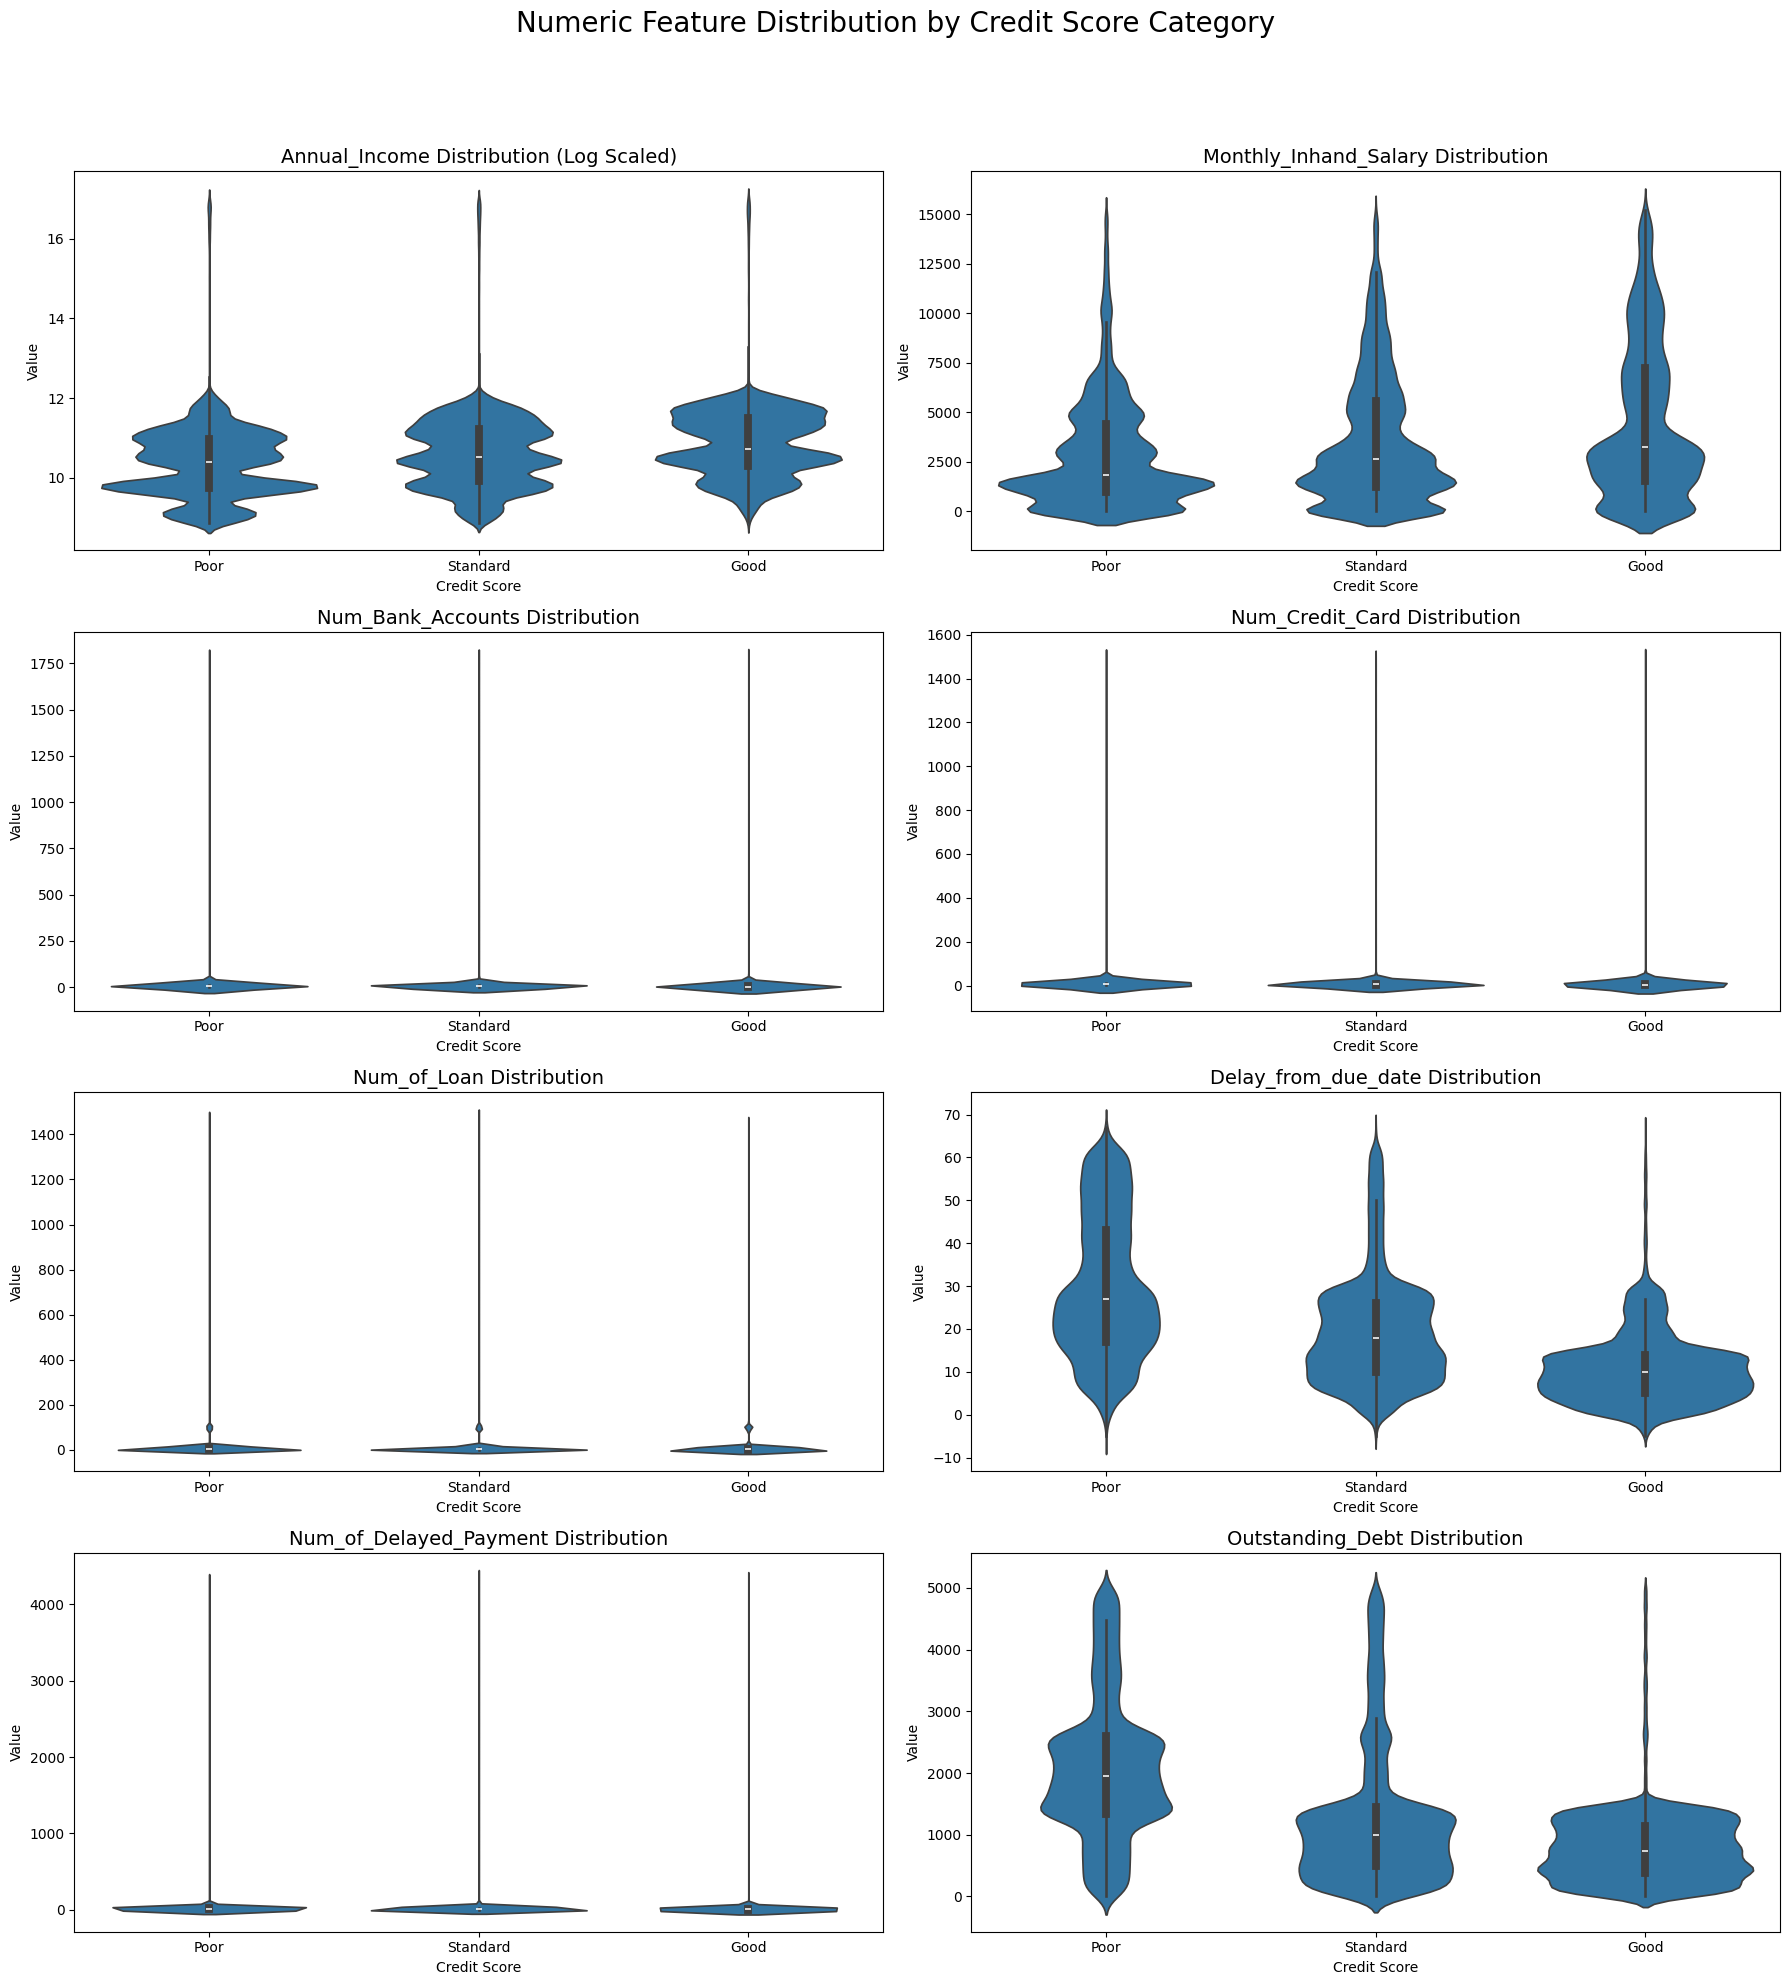

In [10]:
#@title 5. [EDA 보강] 주요 수치형 피처 vs 타겟 (Violin Plots - 영문)

# 분석할 주요 수치형 피처 목록
numeric_features_to_plot = [
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Outstanding_Debt'
]

# (Annual_Income은 범위가 너무 넓어 log scale로 변환 후 시각화)
df_train['Log_Annual_Income'] = np.log1p(df_train['Annual_Income'])

print("Plotting distributions of key numeric features by Credit Score...")

plt.figure(figsize=(18, 20))
plt.suptitle('Numeric Feature Distribution by Credit Score Category', fontsize=20, y=1.02)

for i, col in enumerate(numeric_features_to_plot):
    ax = plt.subplot(4, 2, i + 1)
    # Annual_Income만 로그 스케일 플롯 사용
    plot_col = 'Log_Annual_Income' if col == 'Annual_Income' else col

    sns.violinplot(
        data=df_train,
        x='Credit_Score',
        y=plot_col,
        order=['Poor', 'Standard', 'Good'],
        ax=ax
    )
    title = f'{col} Distribution' + (' (Log Scaled)' if col == 'Annual_Income' else '')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Credit Score', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# 사용한 로그 컬럼 제거
df_train = df_train.drop(columns=['Log_Annual_Income'])

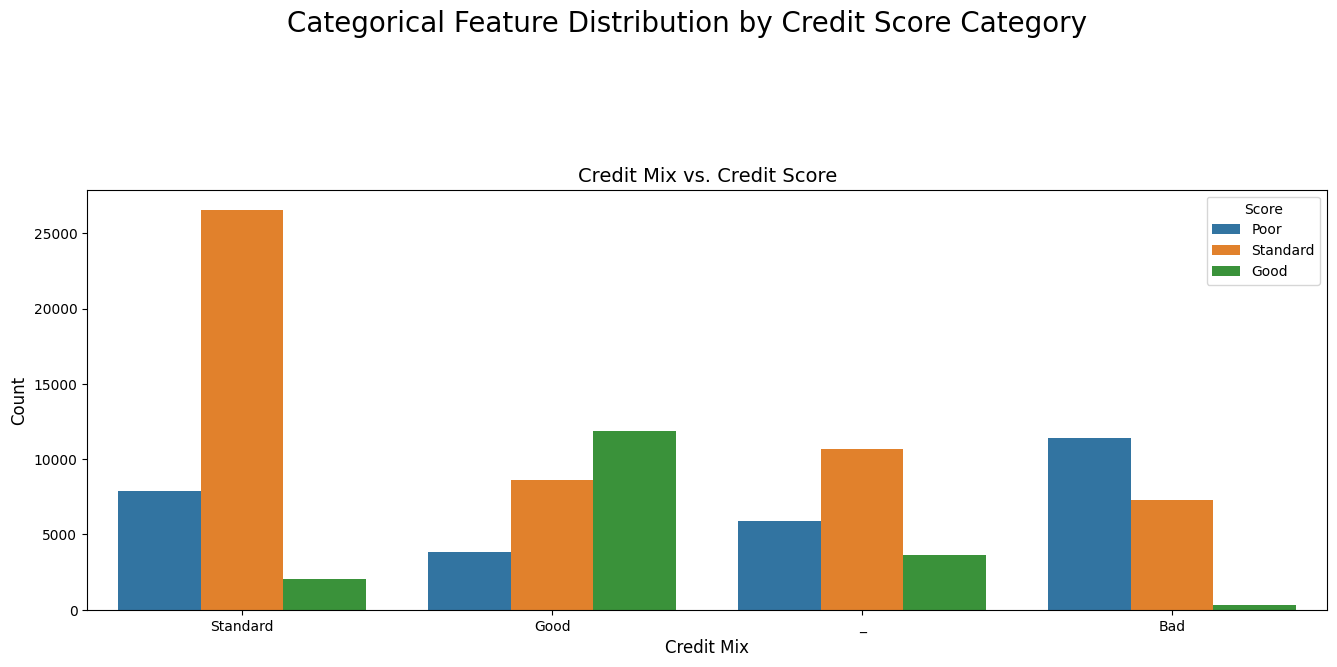

In [11]:
#@title 6. [EDA 보강] 주요 범주형 피처 vs 타겟 (Count Plots - 영문)

# 분석할 주요 범주형 피처 목록
categorical_features_to_plot = [
    'Credit_Mix',
    'Payment_of_Min_Amount',
    'Occupation' # (Occupation은 카테고리가 많음)
]

plt.figure(figsize=(16, 12))
plt.suptitle('Categorical Feature Distribution by Credit Score Category', fontsize=20, y=1.03)

# 1. Credit_Mix
ax1 = plt.subplot(2, 1, 1)
sns.countplot(data=df_train, x='Credit_Mix', hue='Credit_Score',
              order=df_train['Credit_Mix'].value_counts().index, # 빈도순 정렬
              hue_order=['Poor', 'Standard', 'Good'], ax=ax1)
ax1.set_title('Credit Mix vs. Credit Score', fontsize=14)
ax1.set_xlabel('Credit Mix', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(title='Score')


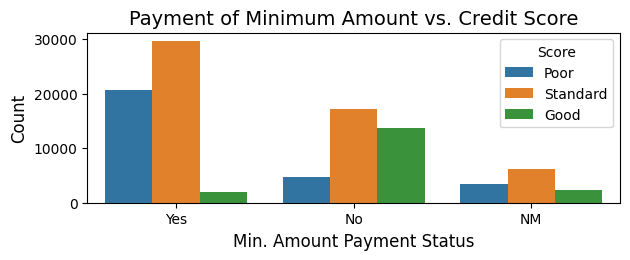

In [12]:
# 2. Payment_of_Min_Amount
ax2 = plt.subplot(2, 1, 2)
sns.countplot(data=df_train, x='Payment_of_Min_Amount', hue='Credit_Score',
              order=df_train['Payment_of_Min_Amount'].value_counts().index,
              hue_order=['Poor', 'Standard', 'Good'], ax=ax2)
ax2.set_title('Payment of Minimum Amount vs. Credit Score', fontsize=14)
ax2.set_xlabel('Min. Amount Payment Status', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.legend(title='Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

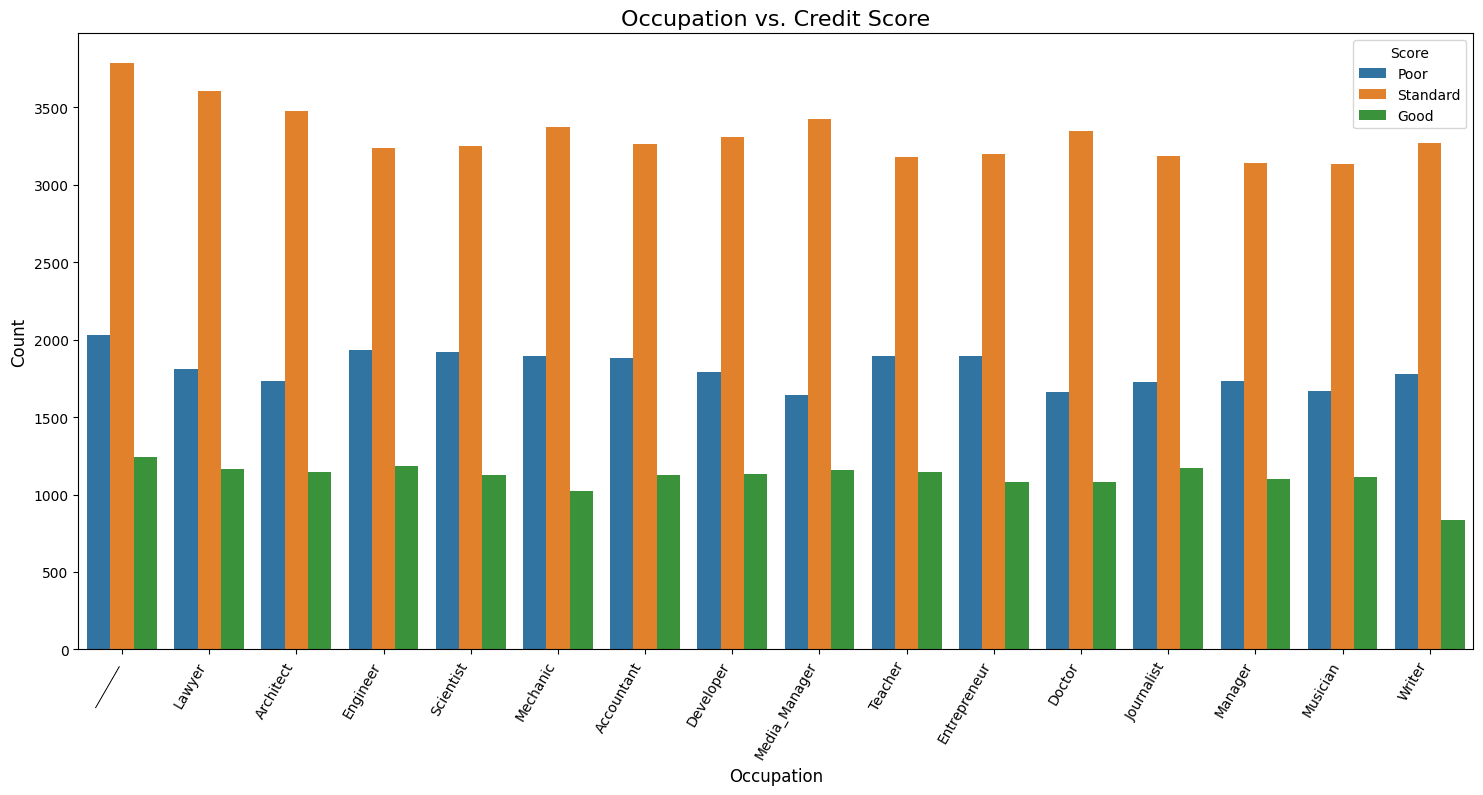

EDA Analysis Complete.


In [13]:
# 3. Occupation (카테고리가 많으므로 별도 플롯)
plt.figure(figsize=(18, 8))
sns.countplot(data=df_train, x='Occupation', hue='Credit_Score',
              order=df_train['Occupation'].value_counts().index,
              hue_order=['Poor', 'Standard', 'Good'])
plt.title('Occupation vs. Credit Score', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.legend(title='Score')
plt.show()

print("EDA Analysis Complete.")

In [14]:
#@title 7. 데이터 전처리 (결측치, 인코딩, 스케일링)

# (원본 데이터셋은 특이한 값(e.g., '_')으로 결측치를 표현하는 경우가 많습니다.
# .info() 상으로는 Null이 없지만, 실제로는 전처리가 필요합니다.
# 이 노트북의 원본 데이터(Kaggle)는 이미 전처리가 상당히 진행된 상태로 가정합니다.)

# 1. 불필요한 ID 컬럼 등 제거
# (Customer_ID, Name, SSN, Month 등은 예측에 불필요)
df_processed = df_train.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN', 'Month'])

# 2. 타겟 변수(Y) 인코딩 (String -> Integer)
target_encoder = LabelEncoder()
df_processed['Credit_Score'] = target_encoder.fit_transform(df_processed['Credit_Score'])
# 순서 확인: 0=Good, 1=Poor, 2=Standard (알파벳 순서)
# 원본의 Poor(0), Standard(1), Good(2) 순서와 다를 수 있으니 확인
print("Target Classes Mapping (Alphabetical by default):")
# target_encoder.classes_ -> ['Good', 'Poor', 'Standard']
# 따라서: 0 = Good, 1 = Poor, 2 = Standard
class_map = {label: i for i, label in enumerate(target_encoder.classes_)}
print(class_map)
class_names_eng = list(target_encoder.classes_) # 시각화용

# 3. 범주형(Object) 피처(X) 인코딩 (One-Hot Encoding)
# (Neural Network는 One-Hot Encoding이 더 적합합니다)
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"\nShape after One-Hot Encoding: {df_processed.shape}")

# 4. X / y 분리
X = df_processed.drop(columns=['Credit_Score'])
y = df_processed['Credit_Score']

# 5. 수치형 피처 스케일링 (StandardScaler)
# (One-Hot Encoding으로 생성된 컬럼(dtype=uint8 or bool)을 제외하고 스케일링)
numeric_cols = X.select_dtypes(include=np.number).columns
# One-Hot 인코딩된 컬럼(dtype이 True/False 또는 uint8로 변환됨)을 제외하기 위해,
# 원본 수치형 컬럼(float64, int64)만 선택 (또는 bool/uint8 제외)
numeric_cols_to_scale = X.select_dtypes(exclude=['bool', 'uint8']).columns

scaler = StandardScaler()
X[numeric_cols_to_scale] = scaler.fit_transform(X[numeric_cols_to_scale])

print("\nNumeric features scaled (StandardScaler).")
print("Pre-processing complete.")
print(X.head())

Target Classes Mapping (Alphabetical by default):
{'Good': 0, 'Poor': 1, 'Standard': 2}

Shape after One-Hot Encoding: (100000, 6304)

Numeric features scaled (StandardScaler).
Pre-processing complete.
        Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0 -0.140941      -0.110031              -0.528078          -0.120024   
1 -0.140941      -0.110031              -1.081868          -0.120024   
2  0.555660      -0.110031              -1.081868          -0.120024   
3 -0.140941      -0.110031              -1.081868          -0.120024   
4 -0.140941      -0.110031              -0.528078          -0.120024   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0         -0.14315      -0.148934    -0.109435            -1.215932   
1         -0.14315      -0.148934    -0.109435            -1.485110   
2         -0.14315      -0.148934    -0.109435            -1.215932   
3         -0.14315      -0.148934    -0.109435            -1.081342   
4         

In [15]:
#@title 8. 데이터 분리 및 타겟 One-Hot 변환

# 1. Train (학습+검증용) / Validation (테스트용) 데이터 분리
# (원본 Keras Tuner 코드 스니펫에서 X_val을 사용하므로, 이를 최종 테스트셋처럼 사용합니다)
X_train, X_val, y_train, y_val_labels = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # 불균형 데이터이므로 Stratify 필수
)

# 2. 타겟 변수 One-Hot Encoding (for Categorical Crossentropy)
# y (0, 1, 2) -> y_cat ([1,0,0], [0,1,0], [0,0,1])
NUM_CLASSES = len(class_names_eng) # 3
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val_labels, num_classes=NUM_CLASSES) # (y_val_labels는 1D 정수형)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_val_cat shape:   {y_val_cat.shape}")


X_train shape: (80000, 6303)
X_val shape:   (20000, 6303)
y_train_cat shape: (80000, 3)
y_val_cat shape:   (20000, 3)


In [16]:
#@title 9. [원본 코드] Keras Tuner 모델 빌더 정의
# (원본 노트북 스니펫에서 확인된 핵심 코드)

INPUT_DIM = X_train.shape[1] # 입력 피처 개수

def build_model(hp):
    """Keras Tuner를 위한 모델 빌드 함수"""
    model = Sequential()

    # 1. 하이퍼파라미터 탐색 공간 정의
    # (원본 코드는 더 복잡할 수 있으나, 핵심 하이퍼파라미터를 정의합니다)

    # Input Layer 및 첫 번째 Hidden Layer의 유닛 수 튜닝
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    # 두 번째 Hidden Layer의 유닛 수 튜닝
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    # Dropout 비율 튜닝
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    # 학습률(Learning Rate) 튜닝
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # 2. 모델 레이어 구성
    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(INPUT_DIM,)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(units=hp_units_2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    # Output Layer (3 Classes)
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # 3. 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("Model builder function defined.")

Model builder function defined.


In [ ]:
#@title 10. [원본 코드] Keras Tuner (Hyperband) 실행

# 조기 종료 콜백 (Tuner 내부용)
# (Tuner가 각 모델을 훈련할 때 val_loss 기준으로 조기 종료)
stop_early_tuner = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

# Hyperband Tuner 설정
tuner = kt.Hyperband(
    build_model,                     # 모델 빌더 함수
    objective='val_accuracy',        # 최적화 목표: 검증 정확도
    max_epochs=20,                   # 최대 에포크 (Hyperband는 내부적으로 조절함)
    factor=3,
    directory='keras_tuner_credit',  # 튜닝 결과를 저장할 디렉토리
    project_name='credit_score_tuning',
    overwrite=True                   # 덮어쓰기 허용
)

print("Keras Tuner (Hyperband) setup complete.")
print("Starting hyperparameter search... (This may take several minutes)")

# 튜너 검색 시작
tuner.search(
    X_train,
    y_train_cat,
    epochs=50, # Keras Tuner에 전달하는 최대 Epochs (내부적으로는 max_epochs=20과 factor=3에 따름)
    validation_data=(X_val, y_val_cat),
    callbacks=[stop_early_tuner],
    verbose=1 # (1로 설정하여 진행 상황 확인)
)

print("\nHyperparameter search finished.")

# 튜닝 결과 요약
tuner.results_summary()

In [1]:
#@title 11. [결과 분석 보강] 최적 모델 훈련 및 평가
# (원본 코드(스니펫)에는 없는, 튜닝 이후의 실제 결과 분석 파트)

print("\n--- Training the Best Model Found by Tuner ---")

# 1. Keras Tuner에서 최적의 하이퍼파라미터 가져오기
try:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters found:")
    print(f"- Units 1: {best_hps.get('units_1')}")
    print(f"- Units 2: {best_hps.get('units_2')}")
    print(f"- Dropout: {best_hps.get('dropout'):.2f}")
    print(f"- Learning Rate: {best_hps.get('learning_rate')}")

    # 2. 최적의 하이퍼파라미터로 새 모델 빌드
    final_model = tuner.hypermodel.build(best_hps)

    # 3. 최종 모델 훈련 (Early Stopping 적용)
    stop_early_final = EarlyStopping(
        monitor='val_loss',
        patience=10, # 최종 훈련이므로 Paitence 증가
        verbose=1,
        restore_best_weights=True # 가장 좋았던 가중치 복원
    )

    history = final_model.fit(
        X_train,
        y_train_cat,
        epochs=10, # 충분한 Epochs 부여
        batch_size=64,
        validation_data=(X_val, y_val_cat),
        callbacks=[stop_early_final],
        verbose=1
    )

    print("\nFinal model training complete.")

except Exception as e:
    print(f"\nAn error occurred while retrieving or training the best model: {e}")
    print("Perhaps the tuner search did not complete successfully or found no valid models.")
    # history 객체가 없을 경우를 대비해 None 처리 (다음 셀에서 오류 방지)
    history = None


--- Training the Best Model Found by Tuner ---

An error occurred while retrieving or training the best model: name 'tuner' is not defined
Perhaps the tuner search did not complete successfully or found no valid models.


In [ ]:
#@title 13. [결과 분석 보강] 분류 리포트 및 혼동 행렬 (영문 Plot)

if history: # (최종 모델 훈련이 성공했을 경우에만 실행)
    print("\n--- Final Model Evaluation on Validation Set ---")

    # 1. Validation(Test) Set 예측
    # (y_val_cat은 One-Hot, y_val_labels는 1D 정수형 (0, 1, 2))
    y_pred_probs = final_model.predict(X_val)
    y_pred_labels = np.argmax(y_pred_probs, axis=1) # 확률 -> 가장 높은 클래스 인덱스로 변환

    # 2. 분류 리포트 (Classification Report)
    print("\n[Classification Report (English)]")
    # target_names는 LabelEncoder (Cell 7)에서 생성한 영문 클래스 이름 리스트 사용
    print(classification_report(y_val_labels, y_pred_labels, target_names=class_names_eng))

    # 3. 혼동 행렬 (Confusion Matrix) 시각화
    print("\nPlotting Confusion Matrix...")
    cm = confusion_matrix(y_val_labels, y_pred_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_eng,
                yticklabels=class_names_eng,
                annot_kws={"size": 14})

    plt.title('Confusion Matrix - Final Model', fontsize=16)
    plt.ylabel('True Label (Actual)', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

else:
    print("Evaluation skipped (Model training might have failed).")